In [1]:
import pandas as pd
import numpy as np
import matplotlib

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv("Hip_Hop _ Vocab_Chart-Full.csv")

**Beginning of Exloratory Data Analysis**

Going to peak at the dataset and see what the variable types are

In [4]:
data.head()

,notes,recalc,era,rapper,rapper_clean,color,words,id,source
0,NaN,2988.0,2010s,21 Savage,21 Savage,NaN,2988,21-savage,new
1,NaN,3812.0,2010s,2 Chainz,2 Chainz,NaN,4148,2chainz,poster
2,NaN,3815.0,1990s,2Pac,2Pac,west nowutang second,"3,970",2pac,site
3,NaN,3384.0,2000s,50 Cent,50 Cent,east nowutang first,"3,591",50-cent,site
4,NaN,4534.0,2010s,Ab-Soul,Ab-Soul,NaN,4534,absoul,new


In [5]:
data.dtypes

notes            object
recalc          float64
era              object
rapper           object
rapper_clean     object
color            object
words            object
id               object
source           object
dtype: object

To begin, I'm going to play around with the naming of some of these variables to my liking. 

[Here's why](https://twitter.com/kanyewest/status/1018432945839673344?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1018432945839673344&ref_url=https%3A%2F%2Fwww.channel24.co.za%2FMusic%2FNews%2Fkanye-west-doesnt-want-journalists-to-call-him-a-rapper-20180716)


[Because ye insist's](https://twitter.com/kanyewest/status/1018433346668453889?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1018433346668453889&ref_url=https%3A%2F%2Fwww.channel24.co.za%2FMusic%2FNews%2Fkanye-west-doesnt-want-journalists-to-call-him-a-rapper-20180716)

In [7]:
data.rename(index=str, columns={"rapper": "artist"}, inplace=True)
data.drop(columns=['rapper_clean', 'notes', 'color'], inplace=True)

'recalc' is 'words' column converted to float, so going to delete 'words' column and rename 'recalc' to 'words'

In [8]:
data.drop(columns=['words'], inplace=True)
data.rename(index=str, columns={"recalc": "words"}, inplace=True)
data.head()

,words,era,artist,id,source
0,2988.0,2010s,21 Savage,21-savage,new
1,3812.0,2010s,2 Chainz,2chainz,poster
2,3815.0,1990s,2Pac,2pac,site
3,3384.0,2000s,50 Cent,50-cent,site
4,4534.0,2010s,Ab-Soul,absoul,new


Most interesting variables to me are which era an artist is from and the number of unique words they have in their lyrics (per first 35,000 words of lyrics). So I'm going to group the dataset by era and get some basic aggregated values.

In [9]:
data.groupby('era').agg(['count', 'mean', 'max', 'min'])

words                             
      count         mean     max     min
era                                     
1980s     8  4207.500000  4655.0  2778.0
1990s    44  4544.704545  6390.0  2936.0
1999s     1  4620.000000  4620.0  4620.0
2000s    50  4633.580000  7879.0  3275.0
2010s    57  3722.807018  5413.0  2472.0

Because 1999s belongs in 1990s and there is only one entry, going to replace 1999s by 1990s

In [10]:
data.replace('1999s', '1990s', inplace = True)

In [11]:
grp_by_era = data.groupby('era').agg(['count', 'mean', 'max', 'min'])
grp_by_era

words                             
      count         mean     max     min
era                                     
1980s     8  4207.500000  4655.0  2778.0
1990s    45  4546.377778  6390.0  2936.0
2000s    50  4633.580000  7879.0  3275.0
2010s    57  3722.807018  5413.0  2472.0

I can see that there is a significant drop in number of unique words for artists in the 2010s era. Going to plot this data to better visualize this. 

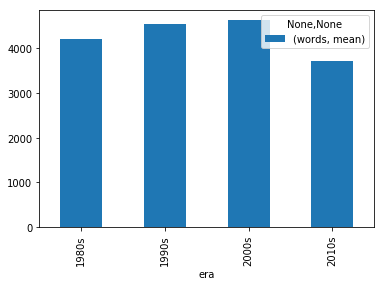

In [12]:
grp_by_era.iloc[:, grp_by_era.columns.get_level_values(1)=='mean'].plot.bar()

Now, the question I want to answer is, **is the drop in number of unique words in an artist's lyrics in the 2010s era statistically significant?**

To begin, what I'm essentially doing is comparing means of more than two groups. To compare the means of two groups, I could do a T- test, however, because we have 4 groups (eras), I must do a one-way ANOVA (Analysis of Variance)test.

ANOVA test is used to determine whether there are any statistically significant differences between means of three or more groups. It is key to rememeber that ANOVA is an "omnibus" test, i.e it only tells us if two or more groups are different statistically significantly. (yikes, wording). 

Before I perform an ANOVA test, I must first make sure that the dataset meets **three conditions**: 
    * The residuals of the dependent variable (in this case, 'words') are normally distributed --> * Normality *
    * The variance in the data for each group are equal --> * Homoegeniety of variance *
    * *Independence of observations*

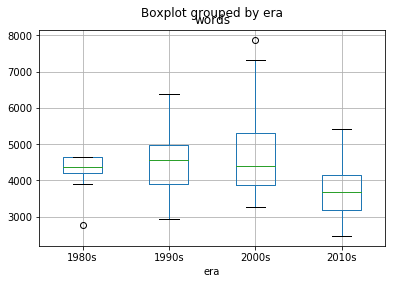

In [11]:
data[['era','words']].boxplot('words', by='era')

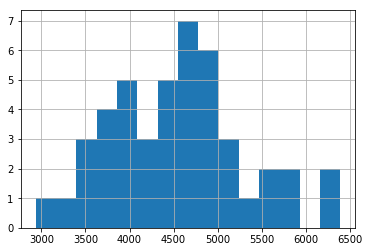

In [41]:
data['words'][data['era'] == '1990s'].hist(bins=15)

In [17]:
from scipy import stats

In [26]:
shap_test_ninties = stats.shapiro(data['words'][data['era'] == '1990s'])
shap_test_twentytens = stats.shapiro(data['words'][data['era'] == '2010s'])
shap_test_ninties, shap_test_twentytens

((0.9846952557563782, 0.8083436489105225),
 (0.9788727760314941, 0.4170992374420166))

In [13]:
# anova test to see atleast one mean is statistically different from the rest, given low p-val, yes.
stats.f_oneway(data['words'][data['era'] == '1980s'],
             data['words'][data['era'] == '1990s'],
             data['words'][data['era'] == '2000s'],
             data['words'][data['era'] == '2010s'])

F_onewayResult(statistic=12.866508141122921, pvalue=1.4814110468608688e-07)

In [14]:
# fishers LSD to find out which means are stat. diff.
# drop from 2000s to 2010s (and 1990s to 2010s) is stat. sig
a = stats.ttest_ind(data['words'][data['era'] == '1980s'], data['words'][data['era'] == '1990s'])
b = stats.ttest_ind(data['words'][data['era'] == '1980s'], data['words'][data['era'] == '2000s'])
c = stats.ttest_ind(data['words'][data['era'] == '1980s'], data['words'][data['era'] == '2010s'])
d = stats.ttest_ind(data['words'][data['era'] == '1990s'], data['words'][data['era'] == '2000s'])
e = stats.ttest_ind(data['words'][data['era'] == '1990s'], data['words'][data['era'] == '2010s'])
f = stats.ttest_ind(data['words'][data['era'] == '2000s'], data['words'][data['era'] == '2010s'])
a,b,c,d,e,f

(Ttest_indResult(statistic=-1.1733684971843248, pvalue=0.24609899989971892),
 Ttest_indResult(statistic=-1.115576134045436, pvalue=0.26936798984985877),
 Ttest_indResult(statistic=1.860506106507783, pvalue=0.06748256111528092),
 Ttest_indResult(statistic=-0.4584792347596082, pvalue=0.6476777898993749),
 Ttest_indResult(statistic=5.654852370186192, pvalue=1.4834503913307314e-07),
 Ttest_indResult(statistic=5.358893197884523, pvalue=4.989772891200519e-07))

In [15]:
# alternatively can do one_way anova tests but doing them pairwise gives same res as doing t tests 
# (which are by def supposed to be done between 2 groups)
data_anova = data[['era','words']].groupby(['era'])
anova_res_1 = stats.f_oneway(data_anova.get_group('2000s')['words'],data_anova.get_group('2010s')['words'])
anova_res_2 = stats.f_oneway(data_anova.get_group('1980s')['words'],data_anova.get_group('1990s')['words'])
anova_res_3 = stats.f_oneway(data_anova.get_group('1990s')['words'],data_anova.get_group('2000s')['words'])
anova_res_1, anova_res_2,anova_res_3

(F_onewayResult(statistic=28.71773630633302, pvalue=4.989772891200487e-07),
 F_onewayResult(statistic=1.3767936301846004, pvalue=0.24609899989971723),
 F_onewayResult(statistic=0.210203208705756, pvalue=0.6476777898993765))

In [42]:
# need to check whether conditions meet for doing anova test
# levene test checks for homogeneity of var between groups
# since not stat sig (p-val greater that 0.05), can assume this condition
# need to be more sure of this and check all conditions before doing anova tests
stats.levene(data['words'][data['era'] == '1990s'],
             data['words'][data['era'] == '2010s'])

LeveneResult(statistic=0.16867706840554048, pvalue=0.68216893335208)

In [17]:
# this is just to know who the min max artists are 
max_idx = data[['era','words','rapper_clean']].groupby('era')['words'].idxmax()
min_idx = data[['era','words','rapper_clean']].groupby('era')['words'].idxmin()
max_words = data.loc[max_idx,][['era','words','rapper_clean']]
min_words = data.loc[min_idx,][['era','words','rapper_clean']]

In [18]:
max_words.head()

,era,words,rapper_clean
11,1980s,4655.0,Big Daddy Kane
57,1990s,6390.0,GZA
6,2000s,7879.0,Aesop Rock
154,2010s,5413.0,Watsky


In [19]:
min_words.head()

,era,words,rapper_clean
143,1980s,2778.0,Too Short
41,1990s,2936.0,DMX
72,2000s,3275.0,Juicy J
114,2010s,2472.0,NF
